In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


db = pd.read_csv('datasets/bike_munich/rad_tage.csv')

# -- Step 1: Add features --
db['temp_diff'] = db['max-temp'] - db['min-temp']
db['sun_to_cloud_ratio'] = db['sonnenstunden'] / (db['bewoelkung'] + 1)  # +1 to avoid division by zero
db['rain_binary'] = (db['niederschlag'] > 0).astype(int)
db['extreme_weather_flag'] = ((db['niederschlag'] > 10) | (db['temp_diff'] < 5)).astype(int)

# Date to datetime
db['datum'] = pd.to_datetime(db['datum'], errors='coerce')
db['wochentag'] = db['datum'].dt.day_name()
db['monat'] = db['datum'].dt.month
db['is_weekend'] = db['wochentag'].isin(['Saturday', 'Sunday']).astype(int)

# Encode wochentag
db['wochentag_encoded'] = db['wochentag'].astype('category').cat.codes

# New interaction features
db['warm_sunny_day'] = ((db['temp_diff'] > 10) & (db['sonnenstunden'] > 5)).astype(int)
db['bad_weather'] = ((db['niederschlag'] > 1) | (db['extreme_weather_flag'] == 1)).astype(int)

# -- Step 2: Drop NA --
db = db.dropna(subset=[
    'gesamt', 'min-temp', 'max-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden',
    'temp_diff', 'sun_to_cloud_ratio'
])

# -- Step 3: Select Features --
feature_cols = [
    'min-temp', 'max-temp', 'niederschlag', 'sonnenstunden',
    'temp_diff', 'sun_to_cloud_ratio', 'rain_binary', 'extreme_weather_flag',
    'wochentag_encoded', 'is_weekend', 'monat',
    'warm_sunny_day', 'bad_weather'
]

X = db[feature_cols]
y = db['gesamt']

# -- Step 4: Train/Test Split --
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -- Step 5: Train Random Forest with regularization --
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
model_rf.fit(X_train, y_train)

# -- Step 6: Evaluate --
y_pred = model_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Test R-squared: {r2}")
print(f"Train R-squared: {model_rf.score(X_train, y_train)}")

# -- Step 7: Predict Tomorrow --
tomorrow = pd.DataFrame([{
    'min-temp': 8.5,
    'max-temp': 17.2,
    'niederschlag': 0.1,
    'sonnenstunden': 6.0,
    'temp_diff': 17.2 - 8.5,
    'sun_to_cloud_ratio': 6.0 / (100 - 6.0 + 1),  # Adjust bewoelkung approx
    'rain_binary': int(0.1 > 0),
    'extreme_weather_flag': int((0.1 > 10) or ((17.2 - 8.5) < 5)),
    'wochentag_encoded': 2,  # e.g., 2 = Wednesday
    'is_weekend': 0,
    'monat': 4,
    'warm_sunny_day': int((17.2 - 8.5 > 10) and (6.0 > 5)),
    'bad_weather': int((0.1 > 1) or int((0.1 > 10) or ((17.2 - 8.5) < 5)))
}])

tomorrow_pred = model_rf.predict(tomorrow)
print(f"Tomorrow's Predicted Bike Traffic: {tomorrow_pred[0]}")


Mean Squared Error: 2701785.468840551
Test R-squared: 0.19712322480938993
Train R-squared: 0.32736867271231174
Tomorrow's Predicted Bike Traffic: 2617.582755425651


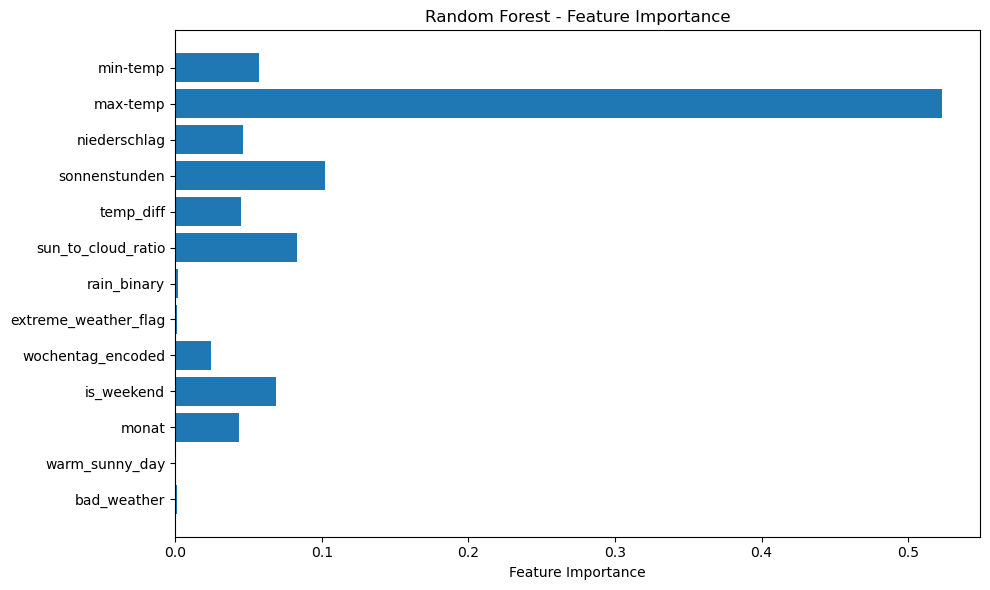

In [2]:
import matplotlib.pyplot as plt

importances = model_rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
